# Use Case 1 : Context-Aware Anomaly Detection im zivilen Luftraum

### 1.1 Die physikalische Ausgangslage
In der Luftfahrt unterliegen alle Bewegungen strengen physikalischen Gesetzen. Obwohl jedes Luftfahrzeug ein individuelles Profil hat, ergibt sich in der Masse ein stabiles Muster.

Es gelten fundamentale Regeln der Aerodynamik:
* **Höhe & Geschwindigkeit:** In dünnerer Luft (hohe Flughöhe) müssen Flugzeuge schneller fliegen, um genügend Auftrieb zu erzeugen.

* **Start & Landung:** Nahe am Boden sind Flugzeuge zwangsläufig langsamer.

**Realistische Benchmarks für "Normalität":**
* **Reiseflughöhe:** Zivile Jets operieren meist zwischen **9.000m und 12.000m**.
* **Reisegeschwindigkeit:** Üblich sind **800 bis 950 km/h**.
* **Stall Speed:** Die meisten Verkehrsflugzeuge benötigen mind. **200-300 km/h**, um stabil zu fliegen.

---

### 1.2 Das Ziel: Anomalie-Erkennung
Wir nutzen den **Isolation Forest**-Algorithmus (Unsupervised Learning), um Datenpunkte zu finden, die massiv von dieser "Norm" abweichen. Dabei suchen wir zwei Arten von Ausreißern:

1.  **Technische Anomalien:** Sensorfehler, bei denen unrealistische Werte übertragen werden (z. B. 10 km/h in 10.000m Höhe).
2.  **Operative Anomalien:** Luftfahrzeuge, die sich am physikalischen Limit bewegen (z. B. Kampfjets im Tiefflug oder extrem langsame Objekte).

---

### 1.3 Data Enrichment & Context-Awareness
Eine rein statistische Analyse hat eine Schwäche: Sie kennt den Unterschied zwischen einem **Airbus A320** und einem **Hubschrauber** nicht. Ein Hubschrauber, der mit 0 km/h schwebt, würde von einem "dummen" Algorithmus als Absturz (Anomalie) markiert werden.

Um dies zu beheben, integrieren wir eine **zweite Datenquelle**.

**Die Datenbasis (Data Engineering):**
Wir nutzen die **OpenSky Aircraft Database**, die wir zuvor über unsere Pipeline (`aircraft_type_ingest_s3.py`) automatisiert ingestiert und als performante **Parquet-Datei** (`aircraft_database.parquet`) bereitgestellt haben.

**Der Kontext-Join:**
Über die eindeutige Transponder-ID (**`icao24`**) verknüpfen wir die Positionsdaten mit den Stammdaten:
* `manufacturerName` (z.B. Airbus, Robinson)
* `model` (z.B. A320, R44)
* `categoryDescription` (z.B. Rotorcraft, Glider)

**Die Forschungsfrage:**
*Ist der gefundene Ausreißer ein physikalischer Fehler (z.B. ein Jet, der zu langsam ist) oder einfach ein Hubschrauber, der sich für seinen Typ völlig normal verhält?*

### Zelle 1: Daten laden & Visualisieren

Diese Zelle bereitet die Analyse-Basis vor und führt einen ersten Plausibilitäts-Check durch:

1.  **Automatischer Import:** Das Skript identifiziert und lädt automatisch den **zeitlich aktuellsten** Datensatz aus der Spark-Verarbeitung (`run_*`), um manuelle Pfad-Anpassungen zu vermeiden.
2.  **Filterung & Bereinigung:** Es werden nur fliegende Objekte (`onground=False`) betrachtet. Datentypen werden korrigiert und die Geschwindigkeit in `km/h` umgerechnet.
3.  **Physik-Visualisierung:** Erstellt ein Streudiagramm (Höhe vs. Geschwindigkeit) mit atmosphärischen Referenzschichten (Troposphäre/Stratosphäre) und Grenzlinien (Mt. Everest, Armstrong-Limit). Dies dient dazu, **grobe Datenfehler** sofort visuell von **echten Flugbewegungen** zu unterscheiden.

--- 1. LADEN & VISUALISIERUNG ---
Lade Datensatz: run_1769360516
Daten geladen: 1,080,730 Punkte.
Erstelle Diagramm mit atmosphärischen Schichten...


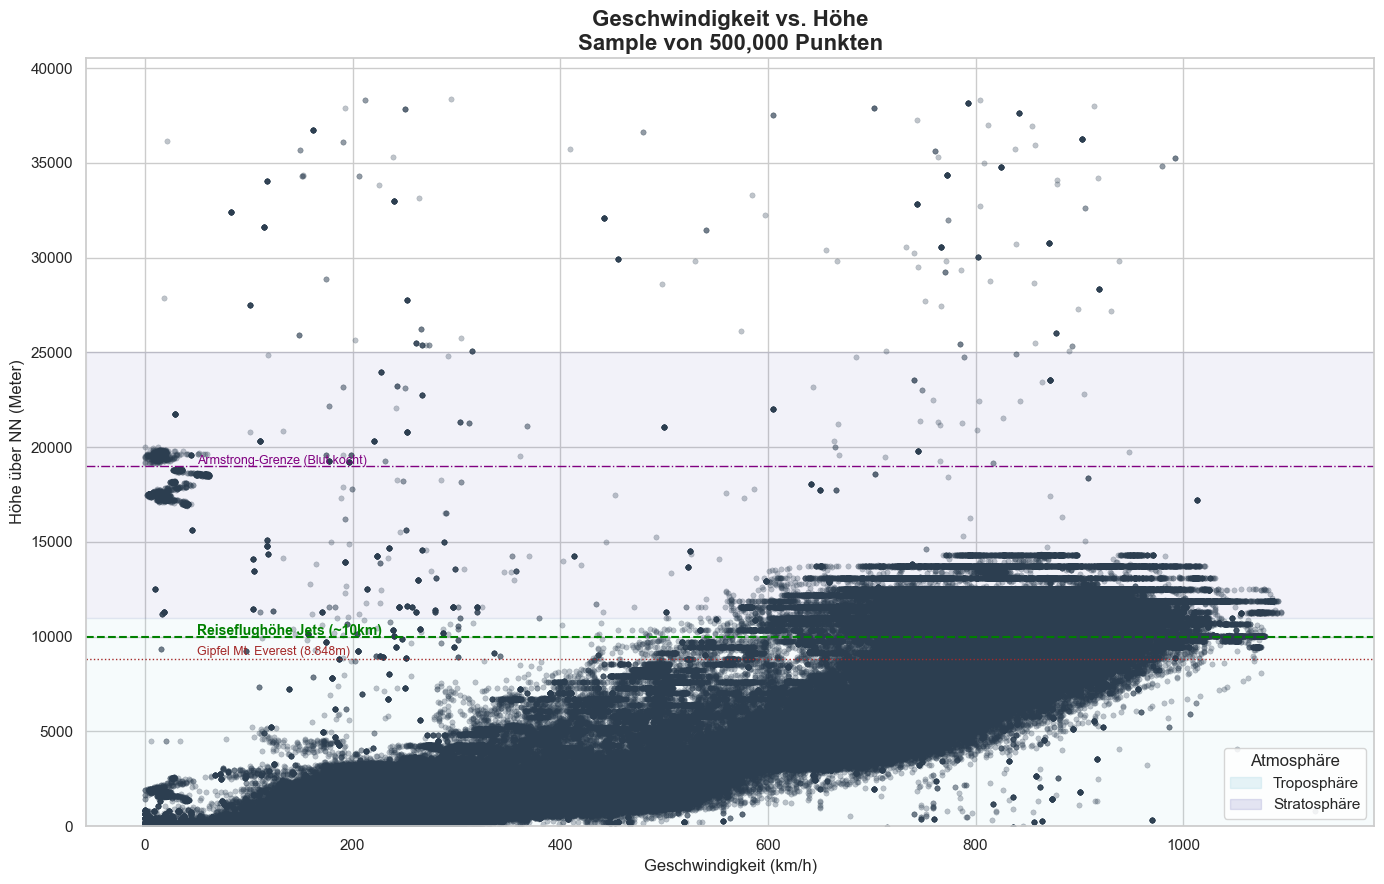

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid")

print("--- 1. LADEN & VISUALISIERUNG ---")

# 1. DATEN LADEN
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*"
latest_run = max(glob.glob(base_path), key=os.path.getctime)
print(f"Lade Datensatz: {os.path.basename(latest_run)}")

df = pd.read_parquet(latest_run)

# 2. DATEN VORBEREITEN
cols_to_fix = ['baroaltitude', 'velocity']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df[df['onground'] == 'False'].dropna(subset=cols_to_fix).copy()
df_clean['velocity_kmh'] = df_clean['velocity'] * 3.6

print(f"Daten geladen: {len(df_clean):,} Punkte.")

# 3. VISUALISIERUNG MIT KONTEXT
print("Erstelle Diagramm mit atmosphärischen Schichten...")
plt.figure(figsize=(14, 9)) # Etwas höher für die Schichten

# SAMPLE HIER EINSTELLEN
sample_size = min(500000, len(df_clean))
df_plot = df_clean.sample(n=sample_size, random_state=42)

# A) HINTERGRUND-SCHICHTEN
plt.axhspan(0, 11000, color='lightblue', alpha=0.1, label='Troposphäre (Wetter)')
plt.axhspan(11000, 25000, color='darkblue', alpha=0.05, label='Stratosphäre')

# B) DER PLOT
sns.scatterplot(
    data=df_plot, 
    x='velocity_kmh', y='baroaltitude',
    color='#2c3e50', alpha=0.3, s=15, edgecolor=None
)

plt.axhline(y=8848, color='brown', linestyle=':', linewidth=1)
plt.text(50, 8900, 'Gipfel Mt. Everest (8.848m)', color='brown', fontsize=9, va='bottom')
plt.axhline(y=10000, color='green', linestyle='--', linewidth=1.5)
plt.text(50, 10100, 'Reiseflughöhe Jets (~10km)', color='green', fontsize=10, fontweight='bold')
if df_clean['baroaltitude'].max() > 15000:
    plt.axhline(y=19000, color='purple', linestyle='-.', linewidth=1)
    plt.text(50, 19100, 'Armstrong-Grenze (Blut kocht)', color='purple', fontsize=9)

# Labels & Titel
plt.title(f"Geschwindigkeit vs. Höhe\nSample von {sample_size:,} Punkten", fontsize=16, fontweight='bold')
plt.xlabel("Geschwindigkeit (km/h)")
plt.ylabel("Höhe über NN (Meter)")
plt.ylim(0, max(14000, df_clean['baroaltitude'].max() * 1.05)) # Y-Achse dynamisch, aber mind. bis 14km

# Legende für die Schichten (Trick mit Fake-Elementen)
tropo_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Troposphäre')
strato_patch = mpatches.Patch(color='darkblue', alpha=0.1, label='Stratosphäre')
plt.legend(handles=[tropo_patch, strato_patch], loc='lower right', title="Atmosphäre")

plt.tight_layout()
plt.show()

### Zelle 2: Geografische Analyse der Anomalien

In diesem Schritt identifizieren wir statistische Ausreißer mittels **Unsupervised Machine Learning** und verorten sie räumlich:

1.  **Isolation Forest:** Das Modell lernt die "normale" Korrelation zwischen Höhe und Geschwindigkeit auf Basis des gesamten Datensatzes. Es markiert die extremsten **1%** der Datenpunkte als Anomalien (`contamination=0.01`).
2.  **Scoring & Ranking:** Jeder Punkt erhält einen **Anomaly Score**. Wir filtern die Top 100 Flugzeuge mit den **stärksten Abweichungen** (negativster Score) heraus, um die gravierendsten Fälle zu isolieren.
3.  **Visualisierung:** Die Anomalien werden auf einer Weltkarte (rot) gegen ein Sample des normalen Verkehrs (grau) geplottet. Dies hilft, geografische Muster zu erkennen (z.B. Häufung von Sensorfehlern in Regionen ohne Radarabdeckung).

--- 2. ANOMALY DETECTION & GEOGRAFISCHE ANALYSE ---
Trainiere Isolation Forest Modell...
Gefundene Anomalien (Gesamt): 10,807
Top 100 extremste Fälle (nach Score dedupliziert) werden geplottet.


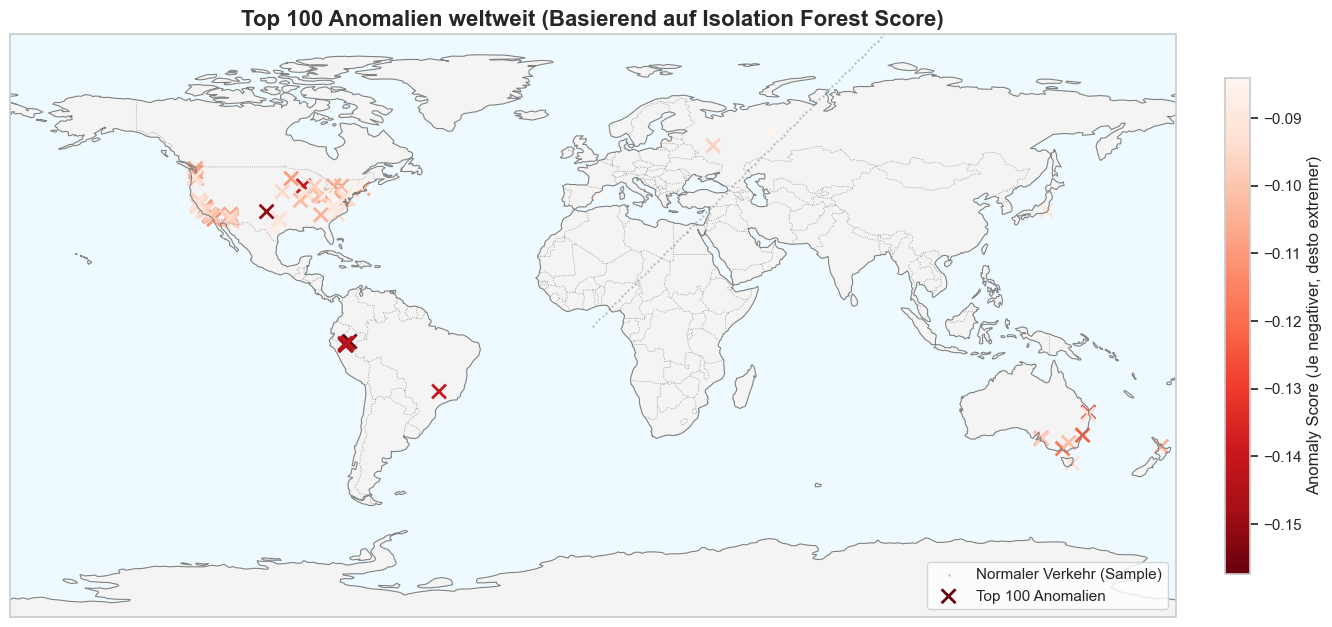

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import IsolationForest
import warnings

# SCHALLDÄMPFER
warnings.filterwarnings('ignore')

print("--- 2. ANOMALY DETECTION & GEOGRAFISCHE ANALYSE ---")

print("Trainiere Isolation Forest Modell...")

# 1. Features auswählen
features = ['velocity_kmh', 'baroaltitude']
X = df_clean[features].fillna(0)

# 2. Modell konfigurieren
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# 3. Trainieren & Vorhersagen
model.fit(X)

# 4. Ergebnisse speichern
df_clean['anomaly_label'] = model.predict(X) # -1 = Anomalie, 1 = Normal
df_clean['anomaly_score'] = model.decision_function(X) # Je kleiner (negativer), desto "schlimmer"

# Nur die Anomalien (-1) herausfiltern
anomalies = df_clean[df_clean['anomaly_label'] == -1].copy()

# Koordinaten sicherstellen
cols_geo = ['lat', 'lon']
for col in cols_geo:
    anomalies[col] = pd.to_numeric(anomalies[col], errors='coerce')

unique_anomalies = anomalies.sort_values('anomaly_score', ascending=True).drop_duplicates(subset=['icao24'])

top_100_anomalies = unique_anomalies.head(100)

print(f"Gefundene Anomalien (Gesamt): {len(anomalies):,}")
print(f"Top 100 extremste Fälle (nach Score dedupliziert) werden geplottet.")

plt.figure(figsize=(16, 10))

# Geo-Projektion
ax = plt.axes(projection=ccrs.PlateCarree())

# Grundkarte
ax.add_feature(cfeature.LAND, facecolor='#f4f4f4') 
ax.add_feature(cfeature.OCEAN, facecolor='#eefaff')     
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='gray')       
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, color='gray') 

# 1. Normaler Verkehr
df_normal = df_clean[df_clean['anomaly_label'] == 1].sample(frac=0.01, random_state=42)
ax.scatter(df_normal['lon'], df_normal['lat'],
           c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree(), label='Normaler Verkehr (Sample)')

# 2. Die Top 100 Anomalien
scatter = ax.scatter(top_100_anomalies['lon'], top_100_anomalies['lat'],
           c=top_100_anomalies['anomaly_score'], # Farbe nach Schweregrad
           cmap='Reds_r', # Dunkelrot = Extrem, Hellrot = Weniger extrem
           s=100, marker='x', linewidth=2, 
           transform=ccrs.PlateCarree(), label='Top 100 Anomalien')

# Design
ax.set_global()
plt.colorbar(scatter, label='Anomaly Score (Je negativer, desto extremer)', fraction=0.02, pad=0.04)
plt.title("Top 100 Anomalien weltweit (Basierend auf Isolation Forest Score)", fontsize=16, fontweight='bold')
plt.legend(loc='lower right')

plt.show()

### Zelle 3: Datenqualität ###
In diesem Schritt validieren wir die Qualität der externen Stammdaten im Verhältnis zu unseren Live-Flugdaten.

--- DATA QUALITY CHECK: DEEP DIVE ---
Total Unique Aircraft im Feed: 4,428
Davon in DB gefunden (Match):  4,415 (99.7%)


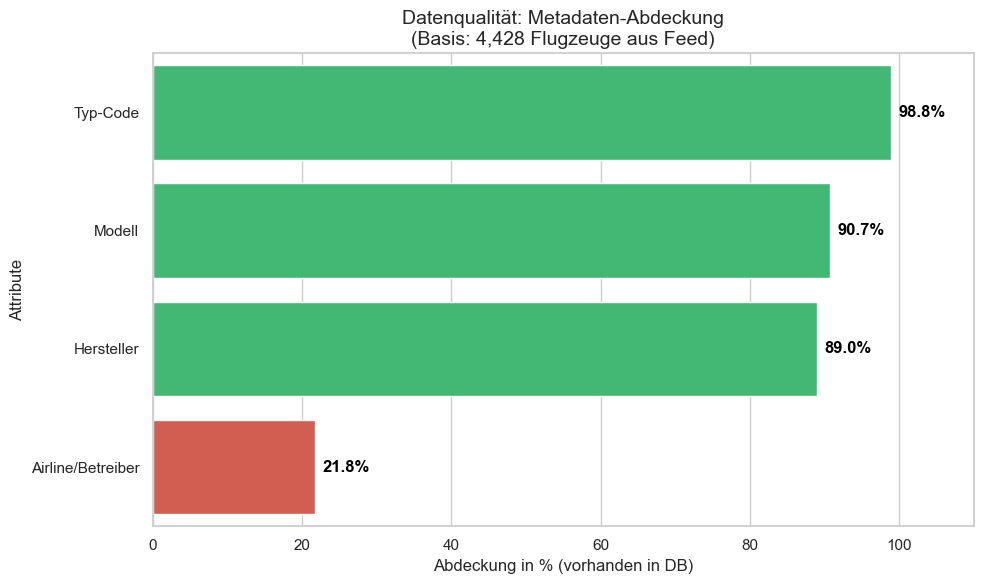

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

print("--- DATA QUALITY CHECK: DEEP DIVE ---")

# 1. DATENBANK LADEN (Direkt als Parquet)
path = "data/external/aircraft_database.parquet"
if not os.path.exists(path):
    path = "../../data/external/aircraft_database.parquet"

df_aircraft = pd.read_parquet(path)

# 2. IDS NORMALISIEREN
feed_ids = df_clean['icao24'].astype(str).str.lower().str.strip().unique()

# Falls icao24 der Index der Parquet ist, schieben wir ihn in eine Spalte
if 'icao24' not in df_aircraft.columns:
    df_aircraft = df_aircraft.reset_index()

df_aircraft['icao24'] = df_aircraft['icao24'].astype(str).str.lower().str.strip()

# 3. MATCHING
df_quality = df_aircraft[df_aircraft['icao24'].isin(feed_ids)].copy()

total_flights = len(feed_ids)
matches_count = len(df_quality)
match_rate = (matches_count / total_flights) * 100 if total_flights > 0 else 0

print(f"Total Unique Aircraft im Feed: {total_flights:,}")
print(f"Davon in DB gefunden (Match):  {matches_count:,} ({match_rate:.1f}%)")

# 4. QUALITÄTS-ANALYSE (Spalten-Vollständigkeit)
attributes = {
    'manufacturername': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ-Code',
    'operator': 'Airline/Betreiber'
}

quality_stats = []
for col, label in attributes.items():
    # Wir suchen die Spalte (case-insensitive)
    actual_col = next((c for c in df_quality.columns if c.lower() == col.lower()), None)
    
    if actual_col:
        # Zähle Einträge die nicht NaN und nicht leerer String sind
        valid_count = df_quality[actual_col].replace(r'^\s*$', np.nan, regex=True).notna().sum()
        pct = (valid_count / total_flights) * 100
        quality_stats.append({'Attribute': label, 'Percentage': pct})
    else:
        quality_stats.append({'Attribute': label, 'Percentage': 0.0})

df_stats = pd.DataFrame(quality_stats).sort_values('Percentage', ascending=False)

# 5. VISUALISIERUNG
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 80 else '#f1c40f' if x > 50 else '#e74c3c' for x in df_stats['Percentage']]

ax = sns.barplot(data=df_stats, x='Percentage', y='Attribute', hue='Attribute', palette=colors, legend=False)

for i, v in enumerate(df_stats['Percentage']):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center', fontweight='bold')

plt.title(f"Datenqualität: Metadaten-Abdeckung\n(Basis: {total_flights:,} Flugzeuge aus Feed)", fontsize=14)
plt.xlabel("Abdeckung in % (vorhanden in DB)")
plt.xlim(0, 110)
plt.tight_layout()
plt.show()

### Zelle 4: Detail-Analyse: Top 50 identifizierte Anomalien

Um die abstrakten Statistik-Werte interpretierbar zu machen, verknüpfen wir sie mit physikalischem Kontext:

1.  **Daten-Fusion:** Wir joinen die Bewegungsdaten (Anomalien) mit der **Aircraft Database**, um Hersteller und Modell zu identifizieren.
2.  **Qualitäts-Filter:** Um Rauschen zu vermeiden, betrachten wir nur **eindeutig identifizierte Flugzeuge**.
3.  **Ranking:** Die Tabelle zeigt die **Top 50** der physikalisch auffälligsten Fälle, sortiert nach ihrem **Risk Score**.

In [5]:
import pandas as pd
import os

print("--- 3. KONTEXT-ANREICHERUNG (Nur identifizierte Flugzeuge) ---")

# Sicherheits-Check
if 'unique_anomalies' not in locals():
    raise ValueError("Bitte führe Zelle 2 aus! Wir brauchen 'unique_anomalies'.")

# 1. STAMMDATEN LADEN
db_path = "../data/external/aircraft_database.parquet"
if not os.path.exists(db_path): db_path = "../../data/external/aircraft_database.parquet"
df_aircraft = pd.read_parquet(db_path)

print(f"Stammdaten geladen. Verknüpfe mit Anomalien...")

# 2. JOIN & FILTER
df_context = pd.merge(unique_anomalies, df_aircraft, on='icao24', how='left')
df_identified = df_context.dropna(subset=['manufacturerName', 'model']).copy()

# 3. SORTIEREN
column_mapping = {
    'anomaly_score': 'Risk Score',
    'icao24': 'ICAO ID',
    'manufacturerName': 'Hersteller',
    'model': 'Modell',
    'typecode': 'Typ',
    'velocity_kmh': 'Speed (km/h)',
    'baroaltitude': 'Höhe (m)'
}

# Spalten auswählen & umbenennen
final_table = df_identified[list(column_mapping.keys())].rename(columns=column_mapping)

# Runden
final_table['Speed (km/h)'] = final_table['Speed (km/h)'].round(1)
final_table['Höhe (m)'] = final_table['Höhe (m)'].round(0)
final_table['Risk Score'] = final_table['Risk Score'].round(4)

# Sortieren: Die schlimmsten Scores nach oben
final_table = final_table.sort_values('Risk Score', ascending=True)

# Top 50 auswählen
top_50 = final_table.head(50)

print(f"✅ Gefiltert: {len(df_identified)} Anomalien mit bekannten Metadaten.")
print("Hier sind die Top 50 identifizierten Fälle:")

display(top_50.set_index('ICAO ID'))

--- 3. KONTEXT-ANREICHERUNG (Nur identifizierte Flugzeuge) ---
Stammdaten geladen. Verknüpfe mit Anomalien...
✅ Gefiltert: 341 Anomalien mit bekannten Metadaten.
Hier sind die Top 50 identifizierten Fälle:


,Risk Score,Hersteller,Modell,Typ,Speed (km/h),Höhe (m)
ICAO ID,,,,,,
a04763,-0.1487,Eurocopter Deutschland Gmbh,MBB-BK 117 C-1,BK17,18.5,27859.0
a5b693,-0.1482,Cessna,T210N,T210,83.0,32400.0
a57369,-0.1418,Bell Helicopter Textron Canada,407,B407,29.3,21763.0
ab0fd6,-0.1387,Piper,PA-28-181,P28A,44.8,19599.0
7c3635,-0.1350,Cessna Aircraft Company,172S,C172,117.1,34046.0
a65512,-0.1288,Md Helicopters Inc,369FF,H500,112.6,28042.0
a1af86,-0.1272,Piper,PA-28R-200,P28R,110.8,20330.0
7c6182,-0.1231,Leonardo,AW.139,A139,45.6,15636.0
a4e569,-0.1215,Piper,PA-28-181,P28A,152.3,34351.0


# Skalierbarkeitsanalyse zu Use Case 1

### Zielsetzung
Dieses Notebook untersucht die **Skalierbarkeit** (Scalability) von Data-Engineering-Pipelines. Wir simulieren wachsende Datenlasten ("Load"), um das Systemverhalten empirisch zu messen.

### Hypothese
Wir erwarten für typische ETL-Operationen (Aggregationen) eine **lineare Zeitkomplexität**. Das bedeutet: Doppelte Datenmenge führt zu doppelter Rechenzeit, während der Durchsatz (Rows/sec) stabil bleiben sollte.

In [ ]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Design-Settings
sns.set_theme(style="whitegrid")

print("--- 1. SETUP: DATEN LADEN ---")
# Wir laden den aktuellsten Spark-Run
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*"
latest_run = max(glob.glob(base_path), key=os.path.getctime)

print(f"Lade Datensatz: {os.path.basename(latest_run)}")
df_full = pd.read_parquet(latest_run)

# Cleaning & Typisierung
cols = ['velocity', 'baroaltitude']
for c in cols: df_full[c] = pd.to_numeric(df_full[c], errors='coerce')
df_clean = df_full[df_full['onground'] == 'False'].dropna(subset=cols).copy()
df_clean['velocity_kmh'] = df_clean['velocity'] * 3.6

print(f"Bereit: {len(df_clean):,} Zeilen im RAM.")

--- 1. SETUP: DATEN LADEN ---
Lade Datensatz: run_1769360516
Bereit: 1,080,730 Zeilen im RAM.


### Experiment 1: AI Inference Scalability (Durchsatz)

Wir untersuchen die **Vorhersage-Skalierbarkeit** unseres Anomaly-Detection-Modells. Simuliert wird ein Szenario, in dem das trainierte Modell im Echtzeit-Betrieb auf ein massiv steigendes Verkehrsaufkommen reagieren muss.

* **Variable:** Batch-Größe
* **Metrik:** Durchsatz (**Predictions per Second**).
* **Methode:**
    * Wir nutzen ein vorab trainiertes `IsolationForest` Modell.
    * Bei kleinen Batches (< 1 Mio.) wiederholen wir die Messung **20x**, um System-Rauschen (Overhead) zu glätten.
    * Bei großen Batches (> 2 Mio.) reduzieren wir auf **5x**, da die reine Rechenzeit für eine präzise Messung ausreicht.
* **Erwartung:** Wir prüfen, ob das System "Economies of Scale" zeigt.

--- 2. SCALABILITY TEST: AI INFERENCE (FIXED) ---
🛠️ Initialisiere AI-Modell (Isolation Forest)...
✅ Modell bereit. Starte Stress-Test (Inference)...
   Last: 0.2x |    216,146 Flieger | Zeit: 1.1158s | Speed: 193,708 Predictions/s
   Last: 0.4x |    432,292 Flieger | Zeit: 2.2135s | Speed: 195,297 Predictions/s
   Last: 0.6x |    648,438 Flieger | Zeit: 3.3103s | Speed: 195,887 Predictions/s
   Last: 0.8x |    864,584 Flieger | Zeit: 4.4509s | Speed: 194,247 Predictions/s
   Last: 1.0x |  1,080,730 Flieger | Zeit: 5.4639s | Speed: 197,794 Predictions/s
   Last: 1.2x |  1,296,876 Flieger | Zeit: 6.6621s | Speed: 194,663 Predictions/s
   Last: 1.4x |  1,513,022 Flieger | Zeit: 7.5201s | Speed: 201,195 Predictions/s
   Last: 1.6x |  1,729,168 Flieger | Zeit: 8.6990s | Speed: 198,778 Predictions/s
   Last: 1.8x |  1,945,314 Flieger | Zeit: 9.4750s | Speed: 205,309 Predictions/s
   Last: 2.0x |  2,161,460 Flieger | Zeit: 10.6526s | Speed: 202,903 Predictions/s


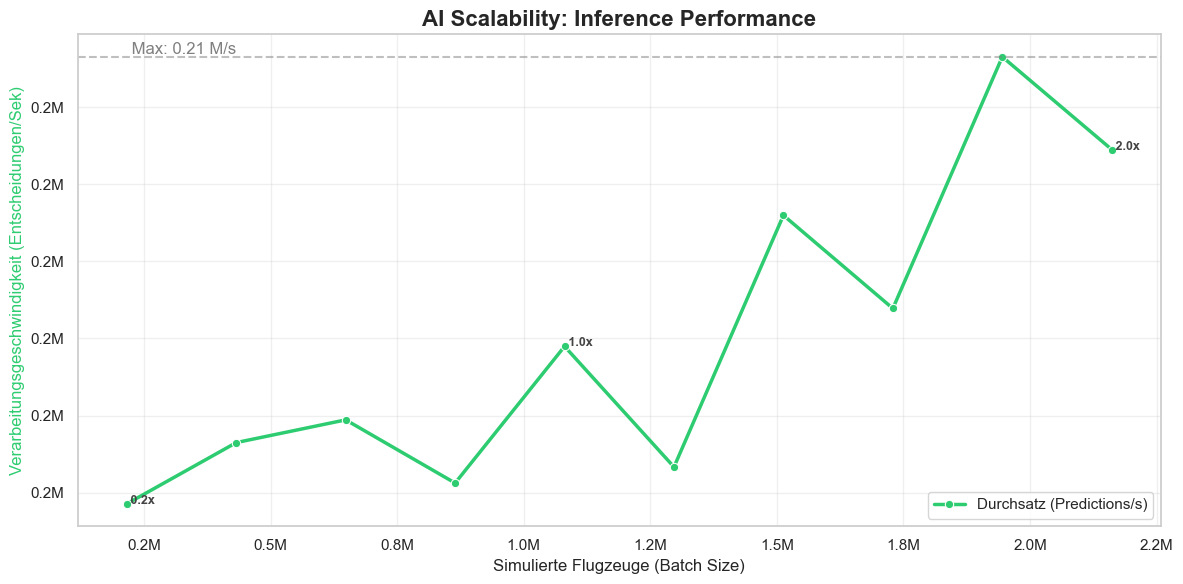

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import IsolationForest

print("--- 2. SCALABILITY TEST: AI INFERENCE (FIXED) ---")

# 1. SETUP: Modell einmalig trainieren
print("🛠️ Initialisiere AI-Modell (Isolation Forest)...")
features = ['velocity_kmh', 'baroaltitude']

# Wir trainieren nur auf einem Teil, damit es schnell geht (max 100k Zeilen)
train_sample = df_clean.sample(n=min(100000, len(df_clean)), random_state=42)
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
model.fit(train_sample[features])
print("✅ Modell bereit. Starte Stress-Test (Inference)...")

# 2. MESSUNG
factors = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0] 
results = []

for f in factors:
    # --- A) DATEN VORBEREITEN (Traffic Generation) ---
    if f <= 1.0:
        # Einfaches Sampling bei < 100%
        df_work = df_clean.sample(frac=f, random_state=42)
    else:
        # Komplexes Sampling bei > 100% (z.B. 1.4x = 1 ganzer + 0.4 Teil)
        full_copies = int(f)
        remainder = f - full_copies
        
        parts = [df_clean] * full_copies
        
        # Den "krummen" Rest dazu packen
        if remainder > 0.001:
            parts.append(df_clean.sample(frac=remainder, random_state=42))
            
        df_work = pd.concat(parts, ignore_index=True)
        
    n_rows = len(df_work)
    
    # --- B) MESSUNG
    start_time = time.time()
    
    # Die AI-Entscheidung: Anomalie Ja/Nein?
    _ = model.predict(df_work[features])
        
    end_time = time.time()
    
    # --- C) AUFRÄUMEN & METRIKEN ---
    if f > 1.0: 
        del df_work # RAM freigeben
    
    duration = end_time - start_time
    throughput = n_rows / duration if duration > 0 else 0
    
    print(f"   Last: {f:3.1f}x | {n_rows:10,} Flieger | Zeit: {duration:6.4f}s | Speed: {int(throughput):,} Predictions/s")
    
    results.append({
        'factor': f,
        'n_rows': n_rows,
        'throughput': throughput
    })

# --- 3. VISUALISIERUNG ---
df_results = pd.DataFrame(results)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot: Durchsatz (Grüne Linie)
sns.lineplot(data=df_results, x='n_rows', y='throughput', marker='o', 
             color='#2ecc71', linewidth=2.5, ax=ax1, label='Durchsatz (Predictions/s)')

ax1.set_title('AI Scalability: Inference Performance', fontsize=16, fontweight='bold')
ax1.set_xlabel('Simulierte Flugzeuge (Batch Size)', fontsize=12)
ax1.set_ylabel('Verarbeitungsgeschwindigkeit (Entscheidungen/Sek)', color='#2ecc71', fontsize=12)

ax1.grid(True, alpha=0.3)

# Achsen formatieren (M = Millionen)
formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M')
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

# Labels an die Punkte schreiben
for x, y, f in zip(df_results['n_rows'], df_results['throughput'], df_results['factor']):
    # Nur jeden zweiten beschriften, damit es nicht zu voll wird
    if f in [0.2, 1.0, 2.0, 3.0, 4.0, 5.0]: 
        ax1.text(x, y, f' {f}x', fontsize=9, fontweight='bold', color='#444')

# Max-Wert markieren
peak_val = df_results['throughput'].max()
ax1.axhline(peak_val, color='gray', linestyle='--', alpha=0.5)
ax1.text(df_results['n_rows'].min(), peak_val, f' Max: {peak_val/1e6:.2f} M/s', va='bottom', color='gray')

plt.tight_layout()
plt.legend()
plt.show()

### Experiment 2: Space Complexity & Stress Test

Nach der Zeit-Analyse prüfen wir nun den **Speicherbedarf** und die **CPU-Nutzung**.
* **Szenario:** Wir simulieren "Big Data", indem wir den Datensatz künstlich vervielfachen (Synthetic Upscaling bis zum 5-fachen Volumen).
* **Metrik:** Peak RAM Usage und CPU Time.
* **Ziel:** Wir wollen ausschließen, dass der Speicherbedarf exponentiell wächst, was das System bei großen Datenmengen zum Absturz bringen würde ("Out of Memory").

--- 3. SYSTEM-STRESS-TEST: RAM & CPU (AI Workload) ---
🛠️ Bereite AI-Modell vor (Isolation Forest)...
✅ Modell bereit. Starte Hardware-Stress-Test...
   Last:  1.2x |  1,296,876 Zeilen | RAM:   93.5 MB | CPU-Load: 99%
   Last:  1.4x |  1,513,022 Zeilen | RAM:  109.0 MB | CPU-Load: 99%
   Last:  1.6x |  1,729,168 Zeilen | RAM:  124.6 MB | CPU-Load: 99%
   Last:  1.8x |  1,945,314 Zeilen | RAM:  140.2 MB | CPU-Load: 99%
   Last:  2.0x |  2,161,460 Zeilen | RAM:  155.7 MB | CPU-Load: 99%


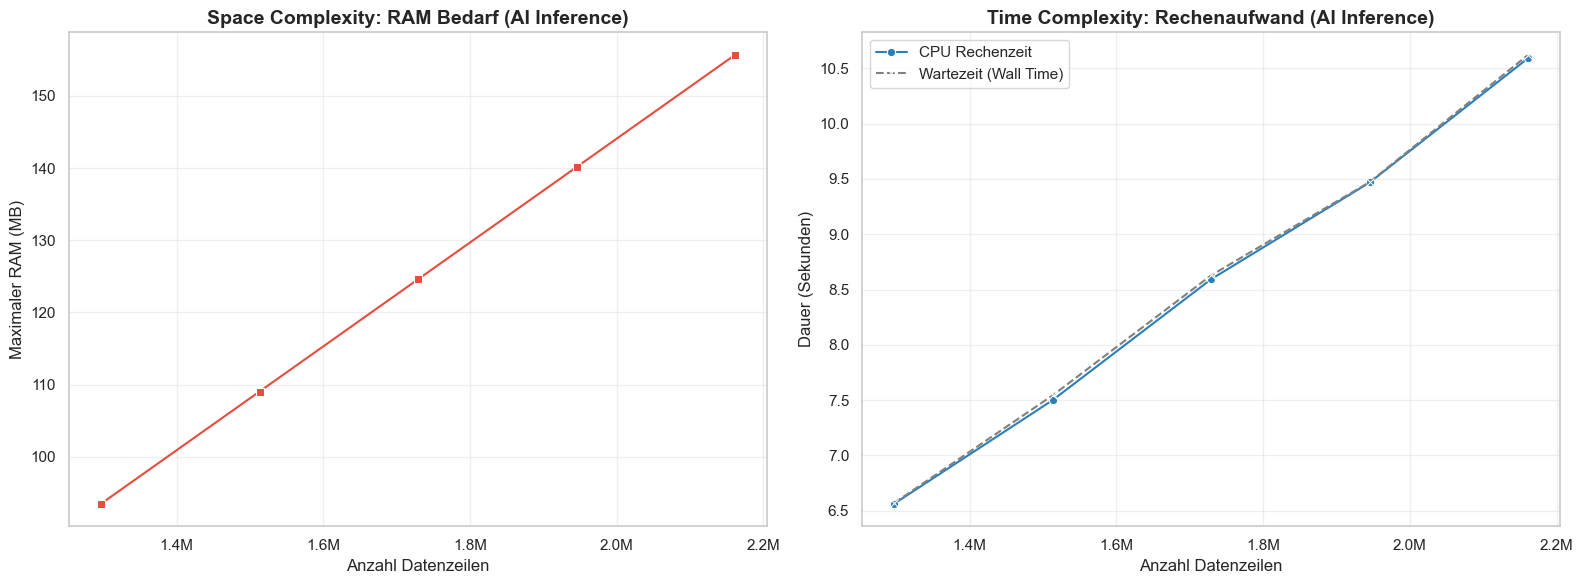

In [7]:
import tracemalloc
import seaborn as sns
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.ensemble import IsolationForest

print("--- 3. SYSTEM-STRESS-TEST: RAM & CPU (AI Workload) ---")

# 1. SETUP: Modell vorbereiten
print("🛠️ Bereite AI-Modell vor (Isolation Forest)...")
features = ['velocity_kmh', 'baroaltitude']
train_sample = df_clean.sample(n=min(50000, len(df_clean)), random_state=42)
model = IsolationForest(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(train_sample[features])
print("✅ Modell bereit. Starte Hardware-Stress-Test...")

# 2. KONFIGURATION (Jetzt mit Kommazahlen!)
multipliers = [1.2, 1.4, 1.6, 1.8, 2] 
stress_results = []
original_len = len(df_clean)

for m in multipliers:
    # --- A) DATEN AUFBLÄHEN (Logik für Kommazahlen) ---
    if m <= 1.0:
        # Einfacher Fall: Wir nehmen nur einen Teil
        df_big = df_clean.sample(frac=m, random_state=42)
    else:
        # Komplexer Fall: Ganze Kopien + Rest (z.B. 1.5x)
        full_copies = int(m)           # Der Teil vor dem Komma (1)
        remainder = m - full_copies    # Der Teil nach dem Komma (0.5)
        
        parts = [df_clean] * full_copies # Liste mit ganzen DataFrames
        
        # Wenn es einen Rest gibt, hängen wir den prozentualen Anteil an
        if remainder > 0.001:
            parts.append(df_clean.sample(frac=remainder, random_state=42))
            
        df_big = pd.concat(parts, ignore_index=True)
    
    n_rows = len(df_big)
    
    # --- B) MESSUNG STARTEN ---
    tracemalloc.start()
    start_wall = time.time()       # Echte Zeit
    start_cpu  = time.process_time() # CPU-Zeit
    
    # Workload: AI Inference
    _ = model.predict(df_big[features])
    
    # Messung stoppen
    end_wall = time.time()
    end_cpu  = time.process_time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # C) Metriken berechnen
    duration_wall = end_wall - start_wall
    duration_cpu  = end_cpu - start_cpu
    peak_mb = peak / 10**6
    
    # CPU-Load in %
    cpu_load_pct = (duration_cpu / duration_wall) * 100 if duration_wall > 0 else 0
    
    # Formatierung angepasst für Kommazahlen (z.B. 1.5x)
    print(f"   Last: {m:4.1f}x | {n_rows:10,} Zeilen | RAM: {peak_mb:6.1f} MB | CPU-Load: {int(cpu_load_pct)}%")
    
    stress_results.append({
        'n_rows': n_rows,
        'peak_ram_mb': peak_mb,
        'duration_cpu': duration_cpu,
        'duration_wall': duration_wall,
        'cpu_load_pct': cpu_load_pct
    })
    
    del df_big # Speicher freigeben!

# --- VISUALISIERUNG ---
df_stress = pd.DataFrame(stress_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GRAPH 1: RAM (Space Complexity)
sns.lineplot(data=df_stress, x='n_rows', y='peak_ram_mb', marker='s', color='#e74c3c', ax=ax1)
ax1.set_title('Space Complexity: RAM Bedarf (AI Inference)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax1.set_ylabel('Maximaler RAM (MB)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# GRAPH 2: CPU (Time Complexity)
sns.lineplot(data=df_stress, x='n_rows', y='duration_cpu', marker='o', color='#2980b9', label='CPU Rechenzeit', ax=ax2)
sns.lineplot(data=df_stress, x='n_rows', y='duration_wall', marker='x', color='gray', linestyle='--', label='Wartezeit (Wall Time)', ax=ax2)

ax2.set_title('Time Complexity: Rechenaufwand (AI Inference)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax2.set_ylabel('Dauer (Sekunden)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax2.legend()

plt.tight_layout()
plt.show()

# Use Case 2 : Flugphasen-Analyse

In diesem Schritt erweitern wir die Betrachtung von *Flughöhe* und *Geschwindigkeit* um eine entscheidende dritte Dimension: die **Steigrate (`vertrate`)**.

Im vorherigen Use Case blieb oft unklar, ob ein Flugzeug auf mittlerer Höhe gerade stabil fliegt oder sich in einer dynamischen Phase befindet. Durch die Hinzunahme der Steigrate können wir das Flugverhalten nun präzise segmentieren.

**Vorteile der Vertical-Rate-Analyse:**
* **Klare Phasentrennung:** Wir können zwischen **Start** (positive Steigrate), **Landung** (negative Steigrate) und **Reiseflug** (Steigrate ≈ 0) unterscheiden.
* **Ground Traffic Detection:** Ein Flugzeug am Boden zeichnet sich nicht nur durch niedrige Höhe, sondern zwingend durch eine Steigrate von **0** aus. Dies filtert Fehlmessungen effektiv.
* **Verhaltensmuster:** Anomalien (z.B. schnelles Sinken in großer Höhe) werden sofort sichtbar.


Lade Datensatz aus: ..\..\data\processed\run_1769032455
Daten geladen: 723098 Zeilen.


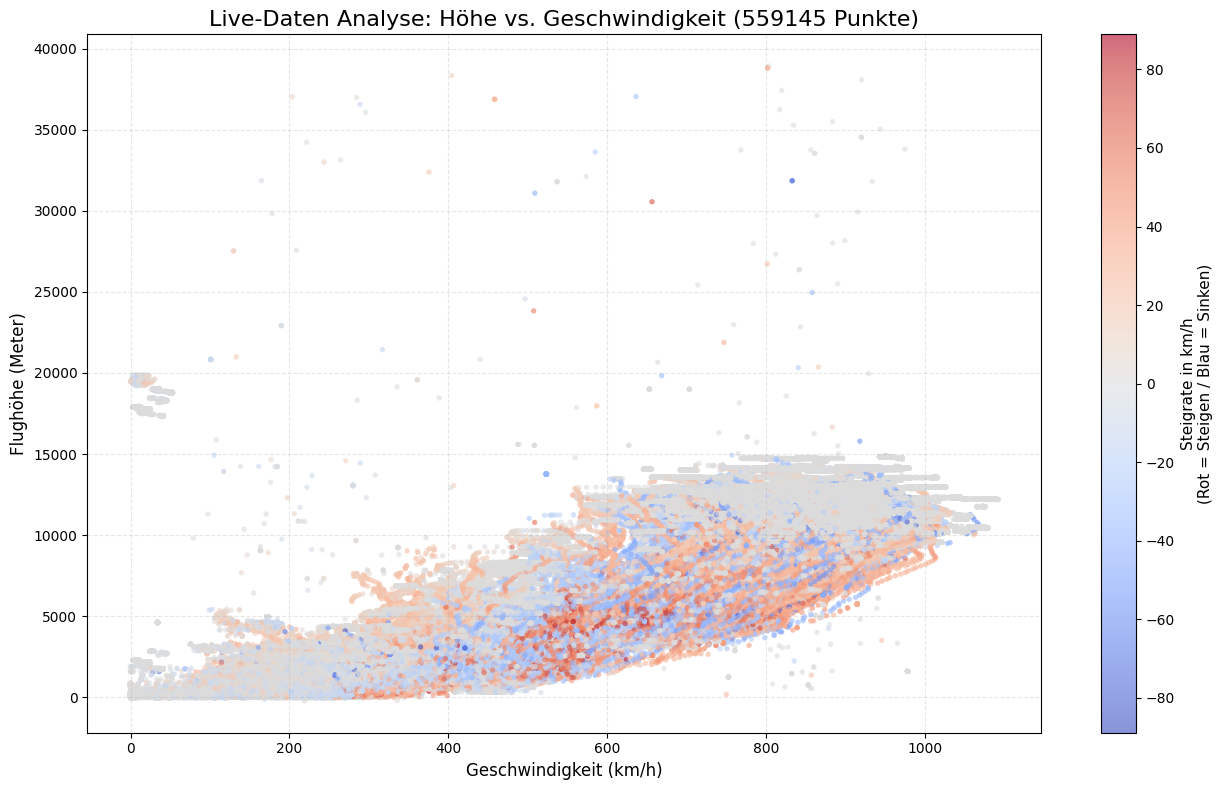

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# --- SCHRITT 1: DATEN LADEN ---
base_dir = os.path.join("..", "..", "data", "processed")

all_runs = glob.glob(os.path.join(base_dir, "run_*"))

if not all_runs:
    print("\nFEHLER: Immer noch keine Daten gefunden.")
    print("Mögliche Ursachen:")
    print("1. Das Spark-Skript lief noch nicht erfolgreich durch.")
    print("2. Der Ordner 'data' liegt woanders als erwartet.")
    df = pd.DataFrame()
else:
    # Den allerneuesten Ordner finden
    latest_run = max(all_runs, key=os.path.getmtime)
    print(f"\nLade Datensatz aus: {latest_run}")
    
    try:
        df = pd.read_parquet(latest_run)
        print(f"Daten geladen: {len(df)} Zeilen.")
    except Exception as e:
        print(f"Fehler beim Lesen: {e}")
        df = pd.DataFrame()

# --- SCHRITT 2: VISUALISIERUNG ---
if not df.empty:
    plot_data = df.copy()
    cols = ['velocity', 'geoaltitude', 'vertrate']
    
    # Cleaning & Casting
    for c in cols:
        plot_data[c] = pd.to_numeric(plot_data[c], errors='coerce')
    plot_data = plot_data.dropna(subset=cols)

    # Umrechnung m/s -> km/h
    plot_data['velocity_kmh'] = plot_data['velocity'] * 3.6
    plot_data['vertrate_kmh'] = plot_data['vertrate'] * 3.6

    # Filter (+/- 90 km/h Steigrate)
    plot_data = plot_data[plot_data['vertrate_kmh'].between(-90, 90)]

    plt.figure(figsize=(13, 8))

    scatter = plt.scatter(
        plot_data['velocity_kmh'], 
        plot_data['geoaltitude'], 
        c=plot_data['vertrate_kmh'], 
        cmap='coolwarm', 
        s=15, 
        alpha=0.6,
        edgecolor='none'
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label('Steigrate in km/h\n(Rot = Steigen / Blau = Sinken)', fontsize=11)

    plt.title(f'Live-Daten Analyse: Höhe vs. Geschwindigkeit ({len(plot_data)} Punkte)', fontsize=16)
    plt.xlabel('Geschwindigkeit (km/h)', fontsize=12)
    plt.ylabel('Flughöhe (Meter)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Auswertung der Grafik ###

Die Visualisierung zeigt eine klare physikalische Trennung der Flugphasen, die durch die Farbkodierung der Steigrate (*Vertical Rate*) bestätigt wird:

1.  **Startphase (Rot):**
    * Sichtbar als Cluster im Bereich niedriger Höhe (< 5.000m) bei mittlerer Geschwindigkeit.
    * Die **rote Färbung** indiziert eine hohe positive Steigrate (Climb).
2.  **Reiseflug (Grau/Weiß):**
    * Dominiert den oberen Bereich des Diagramms (hohe Geschwindigkeit > 800 km/h, große Höhe > 10.000m).
    * Die neutrale Farbe bestätigt eine konstante Höhe (Steigrate ≈ 0), was für maximale Treibstoffeffizienz spricht.
3.  **Landeanflug (Blau):**
    * Erkennbar durch sinkende Geschwindigkeit bei abnehmender Höhe.
    * Die **blaue Färbung** zeigt das aktive Sinken (Descent) an, oft deutlicher ausgeprägt als beim Steigflug.

**Fazit:** Die Hinzunahme der Steigrate ermöglicht eine robuste Klassifizierung des Flugstatus, selbst wenn Höhe und Geschwindigkeit allein keine eindeutige Zuordnung erlauben (z.B. bei Warteschleifen in niedriger Höhe).

--- ANALYSE: TOP 100 HUBS (LOGIC OPTIMIZED) ---
📉 Daten-Reduktion: Von 610470 Signalen auf 3461 einzigartige Flugzeuge am Boden.
📍 Final im Plot: 100 Hubs


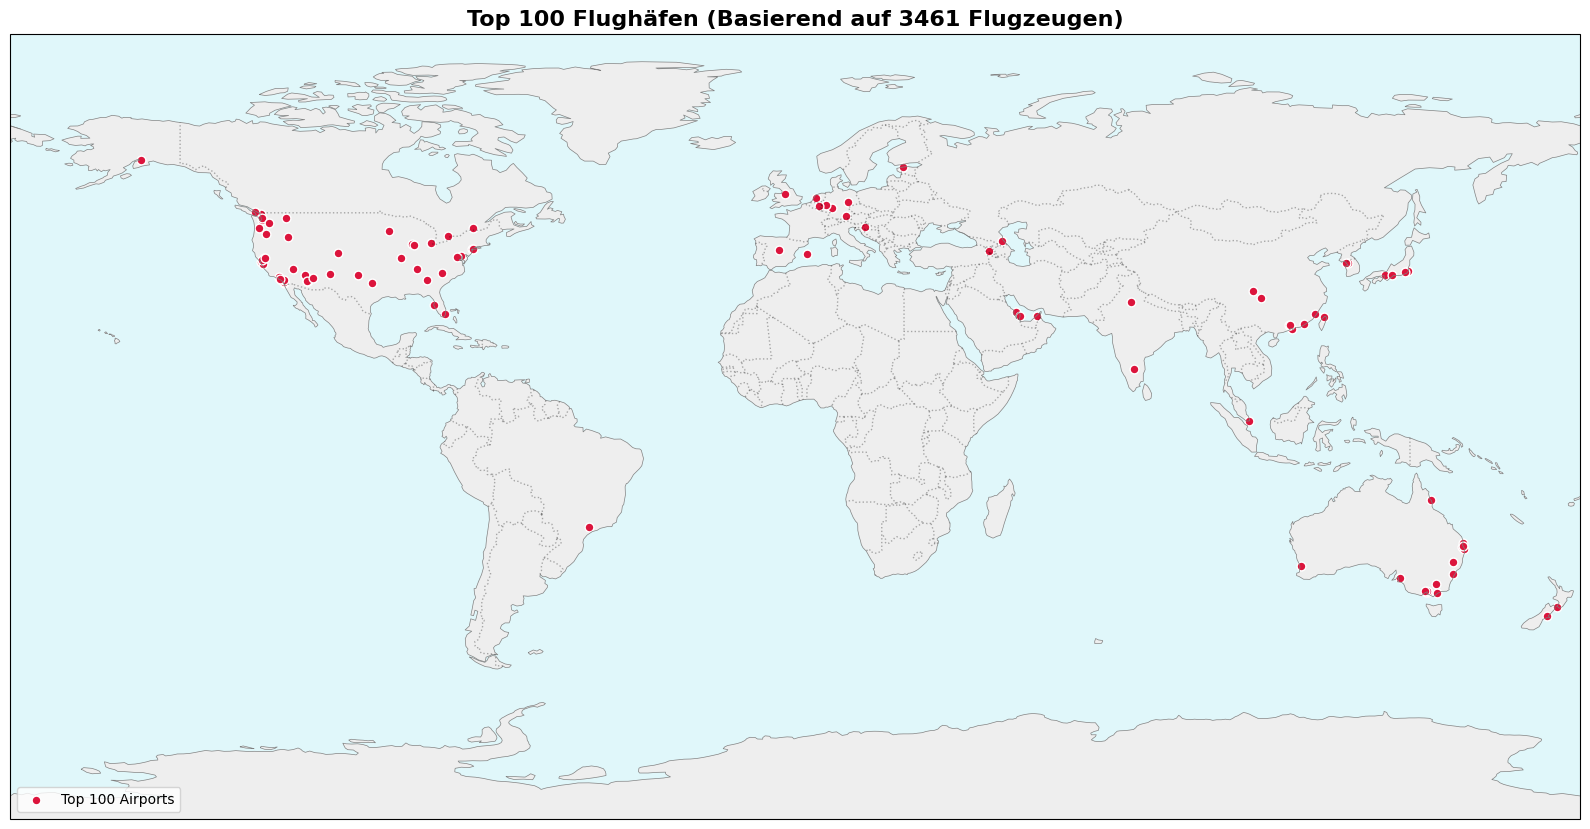

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import warnings

warnings.filterwarnings('ignore')

print("--- ANALYSE: TOP 100 HUBS (LOGIC OPTIMIZED) ---")

# 1. DATEN LADEN
base_dir = os.path.join("..", "..", "data", "processed")
all_runs = glob.glob(os.path.join(base_dir, "run_*"))

if not all_runs:
    print("FEHLER: Keine Daten.")
else:
    latest_run = max(all_runs, key=os.path.getmtime)
    df = pd.read_parquet(latest_run)

    # Typen
    cols = ['lat', 'lon', 'geoaltitude', 'vertrate', 'velocity', 'onground']
    for c in cols:
        if c == 'onground': df[c] = df[c].astype(bool)
        else: df[c] = pd.to_numeric(df[c], errors='coerce')
    
    # Leere Koordinaten weg
    clean_df = df.dropna(subset=['lat', 'lon']).copy()

    # 2. FILTER: NUR FLUGZEUGE AM BODEN
    cond_onground = (clean_df['onground'] == True)
    cond_physics = (
        (clean_df['geoaltitude'] < 500) & 
        (clean_df['velocity'] * 3.6 < 50) & 
        (clean_df['vertrate'].between(-0.5, 0.5))
    )
    
    # Das sind alle Signale vom Boden
    all_ground_signals = clean_df[cond_onground | cond_physics].copy()
    
    # --- 3. DER GAME-CHANGER: EIN FLUGZEUG = EINE STIMME ---
    unique_ground_planes = all_ground_signals.drop_duplicates(subset=['icao24'])
    
    print(f"📉 Daten-Reduktion: Von {len(clean_df)} Signalen auf {len(unique_ground_planes)} einzigartige Flugzeuge am Boden.")

    unique_ground_planes['lat_cluster'] = unique_ground_planes['lat'].round(2)
    unique_ground_planes['lon_cluster'] = unique_ground_planes['lon'].round(2)
    
    # Zählen: Wie viele EINZIGARTIGE Flugzeuge stehen pro Koordinate?
    candidates = unique_ground_planes.groupby(['lat_cluster', 'lon_cluster']).size().reset_index(name='flight_count')
    candidates = candidates.sort_values('flight_count', ascending=False)

    # 5. RÄUMLICHES ENTKERNEN
    lats = candidates['lat_cluster'].values
    lons = candidates['lon_cluster'].values
    active = np.ones(len(candidates), dtype=bool)
    THRESHOLD_DEG = 0.2 
    THRESHOLD_SQ = THRESHOLD_DEG ** 2

    for i in range(len(candidates)):
        if not active[i]: continue
        
        # Distanz zu allen nachfolgenden
        lat_diff = lats[i+1:] - lats[i]
        lon_diff = (lons[i+1:] - lons[i]) * np.cos(np.radians(lats[i]))
        dist_sq = lat_diff**2 + lon_diff**2
        
        # Zu nahe Nachbarn löschen
        too_close = np.where(dist_sq < THRESHOLD_SQ)[0]
        active[i + 1 + too_close] = False

    top_hubs = candidates[active].head(100) # Top 100

    print(f"📍 Final im Plot: {len(top_hubs)} Hubs")

    # 6. PLOT
    plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND, facecolor='#eeeeee')
    ax.add_feature(cfeature.OCEAN, facecolor='#e0f7fa')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.3)

    ax.scatter(
        top_hubs['lon_cluster'], 
        top_hubs['lat_cluster'],
        s=40,
        c='crimson',
        marker='o',
        edgecolor='white',
        linewidth=1,
        transform=ccrs.PlateCarree(),
        label=f'Top {len(top_hubs)} Airports'
    )

    ax.set_global()
    plt.title(f"Top {len(top_hubs)} Flughäfen (Basierend auf {len(unique_ground_planes)} Flugzeugen)", fontsize=16, fontweight='bold')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()